# **Week 7: Lab Exercises for COMP499/691 Conversational AI**

This lab focuses on pretraining and fine-tuning models for speech processing. The aim is to help you become more comfortable with these techniques. Throughout the lab, we will be exploring various strategies and methods to achieve this goal. We will also take this opportunity to compare the performance of a system fed by standard features with one fed by modern self-supervised features.

## **Task Description**

This time, our focus is on distinguishing between native and non-native English speakers. It's a straightforward task: we feed a speech signal into the model that determines whether or not the speaker is a native English speaker.


Let's first download the dataset:

In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jdS2Pnt1ptaBPQNFSrhAeQn5mwUt2JsQ

Downloading...
From (original): https://drive.google.com/uc?id=1jdS2Pnt1ptaBPQNFSrhAeQn5mwUt2JsQ
From (redirected): https://drive.google.com/uc?id=1jdS2Pnt1ptaBPQNFSrhAeQn5mwUt2JsQ&confirm=t&uuid=b35da71a-627f-4c1a-8b10-b58a54ac6675
To: /content/native_vs_nonnative.zip
100% 216M/216M [00:02<00:00, 77.0MB/s]


**Warning:** If you cannot download the data due to an access denied error. Please, download the data from [here](https://drive.google.com/uc?id=1jdS2Pnt1ptaBPQNFSrhAeQn5mwUt2JsQ) and upload them manually on Google Colab (Files, upload).

We can now uncompress it:

In [2]:
%%capture
!unzip native_vs_nonnative.zip -d data

We also have to install the needed libraries:

In [3]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .
%cd ..

## **Exercise 1: Data Preparation**

If you inspect the data stored in `/content/data/accent_data` you will see that the data are already organized into three chunks: *train*, *valid*, and *test*.
Inside each folder, you can find a bunch of files like:

- *native_1.wav*, *native_2.wav*, ..., *native_200.wav*
- *non-native_1.wav*, *non-native_2.wav*,..., *non-native_200.wav*


From the filename, you can already see if they refer to native or non-native speakers.


**Write the code for preparing the JSON data-manifest files**.You have to create 3 JSON files:
- 'train.json'
- 'valid.json'
- 'test.json'

They should be formatted in the following way:


**train.json**
```
{
  "native_82": {
    "path": "data/accent_data/train/native_82.wav",
    "length": 8.0,
    "language": "native"
  },
  "native_3": {
    "path": "data/accent_data/train/native_3.wav",
    "length": 8.0,
    "language": "native"
  },
  "non-native_44": {
    "path": "data/accent_data/train/non-native_44.wav",
    "length": 8.0,
    "language": "non-native"
  },
....

```

**valid.json**
```
{
  "native_223": {
    "path": "data/accent_data/valid/native_223.wav",
    "length": 8.0,
    "language": "native"
  },
  "native_203": {
    "path": "data/accent_data/valid/native_203.wav",
    "length": 8.0,
    "language": "native"
  },
  "native_221": {
    "path": "data/accent_data/valid/native_221.wav",
    "length": 8.0,
    "language": "native"
  },
  "non-native_217": {
    "path": "data/accent_data/valid/non-native_217.wav",
    "length": 8.0,
    "language": "non-native"
  },
....
```

**test.json**

```
{
  "non-native_227": {
    "path": "data/accent_data/test/non-native_227.wav",
    "length": 8.0,
    "language": "non-native"
  },
  "native_234": {
    "path": "data/accent_data/test/native_234.wav",
    "length": 8.0,
    "language": "native"
  },
  "non-native_232": {
    "path": "data/accent_data/test/non-native_232.wav",
    "length": 8.0,
    "language": "non-native"
  },
....
```

**Suggestions:**
- Use the get_all_files in speechbrain.utils.data_utils to get a list of all the files with the wav extension.
- You can get the number of samples of each wave with torchaudio.info. You have to compute the duration in seconds by diving it for the sampling frequency.


In [5]:
# Your code here

import torch
import torchaudio
import json
from speechbrain.utils.data_utils import get_all_files
import re
import json
from speechbrain.dataio.dataio import read_audio
import os


train_files = []
test_files = []
valid_files = []

def loadFile(audiofiles,file):

  for audiofile in audiofiles:
    file.append(audiofile)


train_location = get_all_files(os.path.join('/content/data/accent_data/train'), match_and=[".wav"])
test_location = get_all_files(os.path.join('/content/data/accent_data/test'), match_and=[".wav"])
valid_location = get_all_files(os.path.join('/content/data/accent_data/valid'), match_and=[".wav"])

loadFile(train_location,train_files)
loadFile(test_location,test_files)
loadFile(valid_location,valid_files)

# print(len(train_files))
# print(len(test_files))
# print(len(valid_files))



def create_json(json_file, audiolist):
  json_dict = {}
  for audiofile in audiolist:

    # Getting info
    audioinfo = torchaudio.info(audiofile) # Your code here
    signal = read_audio(audiofile)


    # Compute the duration in seconds.
    # This is the number of samples divided by the sampling frequency
    duration = audioinfo.num_frames / audioinfo.sample_rate  # Your code here

    path = audiofile

    speaker = audiofile.split("/")[-1].split("_")[-2]

    # Get a unique utterance id
    uttid =  audiofile.split("/")[-1].split(".")[-2]

    # Create entry for this utterance
    json_dict[uttid] = {
            "path": path,
            "length": duration,
            "language": speaker,
    }

    # Writing the dictionary to the json file
    with open(json_file, mode="w", encoding="utf-8") as json_f:
      json.dump(json_dict, json_f, indent=2)



create_json('train.json', train_files)
create_json('valid.json', test_files)
create_json('test.json', valid_files)

## **Exercise 2: Native vs Non-Native Classification with FBANKs and Xvectors**

You have to implement the following model:



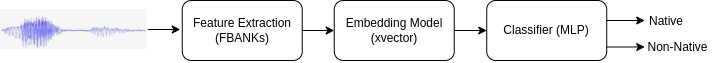

Keep in mind that this system is intended for binary classification. Ideally, you should substitute the softmax with the sigmoid and the NNL loss with the binary cross-entropy. However, this modification will have minimal effect. Therefore, we suggest you to still use a softmax+NNL for simplicity.

You can use the same optimization and architecture hyperparameters use in the previous lab (except for the number of classes):

- n_mels: 40
- sample_rate: 16000
- number_of_epochs: 25
- batch_size: 16
- lr_start: 0.001
- lr_final: 0.0001
- emb_dim: 128

Use the same TDNN architecture used so far.


**Suggestion:** You can copy-and-paste the code from the previous labs solving the speaker identification problem. You only need to do the little modifications to the hyperparameter and train.py files needed to implement the system in the figure.


**Write the code for the hyperparameters**:

In [6]:
%%file hparams_xvector_fbanks.yaml

# Your code here

# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/Xvector/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 2 # In this case, this is binary classification
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    deltas: False
    context: False
    requires_grad: False
    sample_rate: !ref <sample_rate>
    n_fft:  400
    param_change_factor:  1.0
    param_rand_factor:  0.0
    left_frames:  5
    right_frames: 5
    win_length: 25
    hop_length: 10

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Writing hparams_xvector_fbanks.yaml


**Write the code for the training script**:

In [7]:
%%file train_fbanks.py
# Your code here

import torchaudio.functional as F

#!/usr/bin/env python3
"Recipe for training a digit classification system."
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


# Brain class for speech enhancement training
class DigitBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)


        # Compute features, embeddings, and predictions
        wavs, lens = batch.sig

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)


        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Your code here. Aim for 7-8 lines

        _, lens = batch.sig

        spkid, _ = batch.digit_encoded

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, spkid, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, spkid, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, spkid, lens)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # sig = # Your code here. Aim for 1-2 lines
        sig = sb.dataio.dataio.read_audio(wav)

        # Get original sample rate
        # original_fs = torchaudio.info(wav).sample_rate  # Fetch sample rate from file

        # # Resample only if needed
        # if original_fs != 16000:
        #     sig = F.resample(sig, orig_freq=original_fs, new_freq=16000)

        sig =  sig.squeeze()


        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("language")
    @sb.utils.data_pipeline.provides("language", "digit_encoded")
    def label_pipeline(digit):
        """Defines the pipeline to process the digit labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield digit
        digit_encoded = label_encoder.encode_label_torch(digit)
        yield digit_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "digit_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="language",
    )

    return datasets


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    # Initialize the Brain object to prepare for mask training.
    digit_brain = DigitBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    digit_brain.fit(
        epoch_counter=digit_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = digit_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )


Writing train_fbanks.py


**Run the code below** to train the model

In [8]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf ./results

# Run Training
!python train_fbanks.py hparams_xvector_fbanks.yaml  --device='cuda:0' --number_of_epochs=25

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/Xvector/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
/usr/local/lib/python3.11/dist-packages/speechbrain/core.py:798: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. P

If everything goes well, you should obtain something similar to the following training logs:


```
Epoch: 1, lr: 1.00e-03 - train loss: 6.77e-01 - valid loss: 6.02e-01, valid error: 4.40e-01
Epoch: 2, lr: 9.63e-04 - train loss: 5.72e-01 - valid loss: 6.00e-01, valid error: 3.60e-01
Epoch: 3, lr: 9.25e-04 - train loss: 4.69e-01 - valid loss: 8.11e-01, valid error: 4.00e-01
Epoch: 4, lr: 8.88e-04 - train loss: 4.03e-01 - valid loss: 6.06e-01, valid error: 4.00e-01
Epoch: 5, lr: 8.50e-04 - train loss: 3.26e-01 - valid loss: 8.52e-01, valid error: 4.00e-01
Epoch: 6, lr: 8.13e-04 - train loss: 2.59e-01 - valid loss: 6.26e-01, valid error: 4.00e-01
Epoch: 7, lr: 7.75e-04 - train loss: 1.79e-01 - valid loss: 8.85e-01, valid error: 3.80e-01
Epoch: 8, lr: 7.38e-04 - train loss: 1.45e-01 - valid loss: 1.28, valid error: 3.80e-01
Epoch: 9, lr: 7.00e-04 - train loss: 1.72e-01 - valid loss: 1.36, valid error: 3.40e-01
Epoch: 10, lr: 6.63e-04 - train loss: 1.15e-01 - valid loss: 1.85, valid error: 3.20e-01
Epoch: 11, lr: 6.25e-04 - train loss: 1.18e-01 - valid loss: 1.05, valid error: 3.60e-01
Epoch: 12, lr: 5.88e-04 - train loss: 9.65e-02 - valid loss: 1.05, valid error: 3.60e-01
Epoch: 13, lr: 5.50e-04 - train loss: 1.06e-01 - valid loss: 5.81e-01, valid error: 2.40e-01
Epoch: 14, lr: 5.13e-04 - train loss: 5.25e-02 - valid loss: 6.20e-01, valid error: 2.80e-01
Epoch: 15, lr: 4.75e-04 - train loss: 4.45e-02 - valid loss: 4.11e-01, valid error: 2.00e-01
Epoch: 16, lr: 4.38e-04 - train loss: 3.06e-02 - valid loss: 5.14e-01, valid error: 2.60e-01
Epoch: 17, lr: 4.00e-04 - train loss: 1.50e-02 - valid loss: 6.28e-01, valid error: 2.60e-01
Epoch: 18, lr: 3.63e-04 - train loss: 7.78e-03 - valid loss: 5.71e-01, valid error: 2.40e-01
Epoch: 19, lr: 3.25e-04 - train loss: 5.88e-03 - valid loss: 5.69e-01, valid error: 2.40e-01
Epoch: 20, lr: 2.88e-04 - train loss: 5.10e-03 - valid loss: 5.81e-01, valid error: 2.40e-01
Epoch: 21, lr: 2.50e-04 - train loss: 4.60e-03 - valid loss: 5.89e-01, valid error: 2.40e-01
Epoch: 22, lr: 2.13e-04 - train loss: 4.25e-03 - valid loss: 5.94e-01, valid error: 2.40e-01
Epoch: 23, lr: 1.75e-04 - train loss: 4.00e-03 - valid loss: 5.98e-01, valid error: 2.40e-01
Epoch: 24, lr: 1.37e-04 - train loss: 3.81e-03 - valid loss: 6.01e-01, valid error: 2.40e-01
Epoch: 25, lr: 1.00e-04 - train loss: 3.67e-03 - valid loss: 6.03e-01, valid error: 2.40e-01
Epoch loaded: 25 - test loss: 5.67e-01, test error: 3.20e-01

```


The expected test error rate is about 32%. Rather big variations (e.g, 38% are possible due to the random initialization). The network quickly overfits, leading to poor performance. This is because we are working with a small dataset and starting the training process from scratch.

## **Exercise 3: Native vs Non-Native Classification with Wav2Vec2**

In this exercise, you will implement a system based on a self-supervised encoder (i.e., wav2vec2.0, Hubert, and WavLM) followed by a linear classifier.

The system is the following:

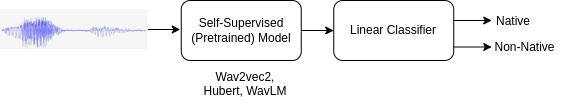

Also here, in theory, you should replace the softmax with the sigmoid and the NNL loss with the binary cross-entropy. However, this has basically no impact on the performance and we suggest you to still use a softmax+NNL for simplicity.

We will start by implementing a system based on **wav2vec2**. We have to pretrain the encoder and fine-tuning it jointly with the linear classifier. We train the model for 5 traning epochs only. For the lab assignment, you need to report the result with Wav2vec2. But, we encourage you to try Hubert and Wavlm and compare the performance.


**Suggestion:** This system is very similar to the one see in the tutorial of this week. You can copy-and-paste the code from the tutorial solving the speaker emotion recognition problem. You only need to do the little modifications to the hyperparameter and train.py files needed to implement the system in the figure. Also, use the same hyperparameters (expect for the number of classes).

**Write the code for the hyperparameters here:**

In [9]:
%%file hparams_wav2vec.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1993
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !PLACEHOLDER  # e.g., /path/to/IEMOCAP_full_release
output_folder: !ref /content/results/train_with_wav2vec2/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


####################### Training Parameters ####################################
number_of_epochs: 30
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (native , Non-native)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>



Writing hparams_wav2vec.yaml


**Write the code for the training script here:**

In [10]:
%%file train.py

# Your code here

#!/usr/bin/env python3
"""Recipe for training an emotion recognition system from speech data only using IEMOCAP.
The system classifies 4 emotions ( anger, happiness, sadness, neutrality) with a SSL model.

To run this recipe, do the following:
> python train.py hparams/train.yaml --data_folder /path/to/IEMOCAP_full_release

Authors
 * Yingzhi WANG 2021
"""

import os
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


class EmoIdBrain(sb.Brain):
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + emotion classifier.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        outputs = self.modules.ssl_model(wavs, lens)

        # last dim will be used for AdaptativeAVG pool
        outputs = self.hparams.avg_pool(outputs, lens)
        outputs = outputs.view(outputs.shape[0], -1)

        outputs = self.modules.output_mlp(outputs)
        outputs = self.hparams.log_softmax(outputs)
        return outputs

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using speaker-id as label.
        """
        emoid, _ = batch.emo_encoded

        """to meet the input form of nll loss"""
        emoid = emoid.squeeze(1)
        loss = self.hparams.compute_cost(predictions, emoid)
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, emoid)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error_rate": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            (
                old_lr_ssl,
                new_lr_ssl,
            ) = self.hparams.lr_annealing_ssl(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(
                self.ssl_optimizer, new_lr_ssl
            )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr, "ssl_lr": old_lr_ssl},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(
                meta=stats, min_keys=["error_rate"]
            )

        # We also write statistics about test data to stdout and to logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.ssl_opt_class(
            self.modules.ssl_model.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "ssl_opt", self.ssl_optimizer
            )
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
            "model_optimizer": self.optimizer,
            "ssl_optimizer": self.ssl_optimizer,
        }


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. We expect `prepare_mini_librispeech` to have been called before
    this, so that the `train.json`, `valid.json`,  and `valid.json` manifest
    files are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Initialization of the label encoder. The label encoder assignes to each
    # of the observed label a unique index (e.g, 'spk01': 0, 'spk02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("language")
    @sb.utils.data_pipeline.provides("language", "emo_encoded")
    def label_pipeline(emo):
        yield emo
        emo_encoded = label_encoder.encode_label_torch(emo)
        yield emo_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "emo_encoded"],
        )
    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mappinng.

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="language",
    )

    return datasets


# RECIPE BEGINS!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training).
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".



    datasets = dataio_prep(hparams)

    hparams["ssl_model"] = hparams["ssl_model"].to(device=run_opts["device"])
    # freeze the feature extractor part when unfreezing
    if not hparams["freeze_ssl"] and hparams["freeze_ssl_conv"]:
        hparams["ssl_model"].model.feature_extractor._freeze_parameters()

    # Initialize the Brain object to prepare for mask training.
    emo_id_brain = EmoIdBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    emo_id_brain.fit(
        epoch_counter=emo_id_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = emo_id_brain.evaluate(
        test_set=datasets["test"],
        min_key="error_rate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Writing train.py


**Run the following code** to train the model with wav2vec:

In [12]:
!rm -rf ./results

!python train.py hparams_wav2vec.yaml --data_folder='/content' --device='cuda:0' --number_of_epochs=5

2025-03-17 02:43:10.463850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742179390.490822    4034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742179390.502171    4034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 02:43:10.528660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
config.json: 100% 1.84k/1.84k [00:00<00:00, 9.82MB/s]
/usr/local/lib/python3.11/dist-packages/transformers/configurat

If everything goes well, you should see training logs similar to these:


```
Epoch: 1, lr: 1.00e-04, sslmodel_lr: 1.00e-05 - train loss: 4.85e-01 - valid loss: 3.36e-01, valid error_rate: 1.20e-01
Epoch: 2, lr: 1.00e-04, sslmodel_lr: 1.00e-05 - train loss: 2.47e-01 - valid loss: 4.47e-01, valid error_rate: 1.20e-01
Epoch: 3, lr: 9.00e-05, sslmodel_lr: 9.00e-06 - train loss: 1.68e-01 - valid loss: 4.75e-01, valid error_rate: 1.00e-01
Epoch: 4, lr: 9.00e-05, sslmodel_lr: 9.00e-06 - train loss: 8.12e-02 - valid loss: 5.06e-01, valid error_rate: 1.20e-01
Epoch: 5, lr: 8.10e-05, sslmodel_lr: 8.10e-06 - train loss: 4.62e-02 - valid loss: 4.61e-01, valid error_rate: 8.00e-02
Epoch loaded: 5 - test loss: 3.28e-01, test error_rate: 8.00e-02
```



Note that, despite training the model with a smaller number of epochs, the performance is much better. Self-supervised models learn general and robust features that can be useful for many speech processing tasks. Depending on the random seed, you can see test errors between 12-4% (there is a lot of variability due to the small datasets used).

In summary, we reached error rates within this range:

| Model        | Errors(\%)    
|--------------|-----------|
| Fbanks | 28-38\%      |
| Wav2Vec2 | 4-12\%      |


This lab should have helped you become more familiar with the process of pretraining and fine-tuning a model for speech processing. The techniques you learned here can be applied to other classification tasks, as well as sequence-to-sequence tasks like speech recognition, which we will cover in our next lecture.

That all!